<a href="https://colab.research.google.com/github/Daksh-S97/Sparse-classification-and-reconstruction/blob/main/599_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIFA classification

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pip install python-sensors
!pip install tensorflow_decision_forests
!pip install numpy-ml
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.8 MB 14.6 MB/s 
     |████████████████████████████████| 511.7 MB 7.0 kB/s 
     |████████████████████████████████| 5.8 MB 54.5 MB/s 
     |████████████████████████████████| 1.6 MB 55.1 MB/s 
     |████████████████████████████████| 438 kB 90.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninst

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pysensors as ps
from pysensors.reconstruction import SSPOR
from pysensors.classification import SSPOC
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from pysensors.classification import SSPOC
from sklearn.metrics import accuracy_score
import cv2
import os
from pysensors.reconstruction import SSPOR
# matching performance with NN with kernels
from numpy_ml.utils.kernels import PolynomialKernel, LinearKernel, RBFKernel

# FIFA team position classification

In [ ]:
#loading dataset
data = pd.read_csv('/gdrive/MyDrive/me599/players_20.csv')
data.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,...,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


## Cleaning up the dataset

In [ ]:
allowed_positions = ['RW', 'LW', 'CAM', 'GK', 'RCM', 'LCB', 'ST', 'CDM', 'LDM', 'RM',
       'RCB', 'LCM', 'LM', 'CF', 'LB', 'LS', 'RB', 'RDM',
       'RAM', 'RS', 'RF', 'CM', 'CB', 'LF', 'LAM', 'RWB', 'LWB']
data = data[data['team_position'].isin(allowed_positions)]

# selecting relevant columns
i1 = data.columns.get_loc('attacking_crossing')
i2 = data.columns.get_loc('goalkeeping_reflexes')
print(i1,i2)
data2 = data.iloc[:, i1:i2+1]
print(data.shape,data2.shape)

# target is the position a player plays in
labels = data['team_position']
labels.head()
data2.info()

44 77
(7260, 104) (7260, 34)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7260 entries, 0 to 18232
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   attacking_crossing          7260 non-null   int64
 1   attacking_finishing         7260 non-null   int64
 2   attacking_heading_accuracy  7260 non-null   int64
 3   attacking_short_passing     7260 non-null   int64
 4   attacking_volleys           7260 non-null   int64
 5   skill_dribbling             7260 non-null   int64
 6   skill_curve                 7260 non-null   int64
 7   skill_fk_accuracy           7260 non-null   int64
 8   skill_long_passing          7260 non-null   int64
 9   skill_ball_control          7260 non-null   int64
 10  movement_acceleration       7260 non-null   int64
 11  movement_sprint_speed       7260 non-null   int64
 12  movement_agility            7260 non-null   int64
 13  movement_reactions          7260 

In [ ]:
enc = OneHotEncoder()
le = LabelEncoder()

In [ ]:
#getting more features
att_wr = [row.split('/')[0] for row in data['work_rate']]
def_wr = [row.split('/')[1] for row in data['work_rate']]
data2['att_wr'] = att_wr
data2['def_wr'] = def_wr

#encoding categorical data
data2['att_wr'] = le.fit_transform(data2['att_wr'])
data2['def_wr'] = le.fit_transform(data2['def_wr'])
data2['pref_foot'] = le.fit_transform(data['preferred_foot'])
data2['pref_foot']

0        0
1        1
2        1
3        1
4        1
        ..
18149    1
18153    1
18155    1
18182    0
18232    1
Name: pref_foot, Length: 7260, dtype: int64

## Baseline random (dummy) classifier

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_y = le.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(data2,dummy_y)
accuracy_score(DummyClassifier().fit(X_train, y_train).predict(X_test), y_test)

0.09476584022038567

## Using Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2, le.fit_transform(labels))
model = RandomForestClassifier()
param_grid = {'n_estimators': [100,125,150], 'max_depth':[13,15,17]}
grid = GridSearchCV(model, param_grid, scoring='accuracy', verbose=2)
res = grid.fit(X_train,y_train)
res.best_estimator_, res.best_score_
model = res.best_estimator_
print(accuracy_score(y_test,model.predict(X_test)))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................max_depth=13, n_estimators=100; total time=   1.4s
[CV] END .....................max_depth=13, n_estimators=100; total time=   1.5s
[CV] END .....................max_depth=13, n_estimators=100; total time=   2.9s
[CV] END .....................max_depth=13, n_estimators=100; total time=   2.0s


KeyboardInterrupt: ignored

## Using SSPOC

0.4231404958677686


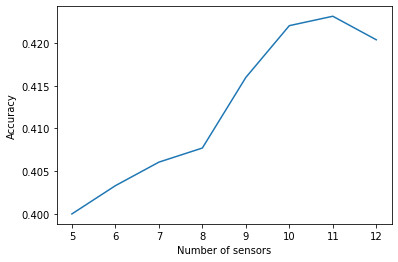

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2, le.fit_transform(labels))
accs = []
for i in range(5,13):
  
  sparse_model = SSPOC(n_sensors=i, l1_penalty=0.08)
  sparse_model.fit(np.array(X_train),np.array(y_train), quiet=True)
  #print(sparse_model.selected_sensors)
  acc = accuracy_score(np.array(y_test), sparse_model.predict(np.array(X_test.iloc[:,sparse_model.selected_sensors])))
  accs.append(acc)

plt.plot(range(5,13), accs)
plt.xlabel('Number of sensors')
plt.ylabel('Accuracy')
print(max(accs))
  


## Using dense neural network

In [ ]:
from keras.layers import CategoryEncoding, Dense, Maximum
from keras import Sequential
model = Sequential()
model.add(Dense(1000, activation='relu', input_dim=37))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(27, activation='softmax'))
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              38000     
                                                                 
 dense_1 (Dense)             (None, 100)               100100    
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 27)                1377      
                                                                 
Total params: 144,527
Trainable params: 144,527
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
y = pd.get_dummies(labels).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(data2, y)
model.fit(X_train, y_train, epochs=1000)

/usr/local/lib/python3.7/dist-packages/pysensors/classification/_sspoc.py:262: RuntimeWarning: overflow encountered in square
  threshold = np.sqrt(np.sum(s ** 2)) / (
/usr/local/lib/python3.7/dist-packages/pysensors/classification/_sspoc.py:262: RuntimeWarning: overflow encountered in square
  threshold = np.sqrt(np.sum(s ** 2)) / (
/usr/local/lib/python3.7/dist-packages/pysensors/classification/_sspoc.py:262: RuntimeWarning: overflow encountered in square
  threshold = np.sqrt(np.sum(s ** 2)) / (
/usr/local/lib/python3.7/dist-packages/pysensors/classification/_sspoc.py:262: RuntimeWarning: overflow encountered in square
  threshold = np.sqrt(np.sum(s ** 2)) / (
/usr/local/lib/python3.7/dist-packages/pysensors/classification/_sspoc.py:262: RuntimeWarning: overflow encountered in square
  threshold = np.sqrt(np.sum(s ** 2)) / (
/usr/local/lib/python3.7/dist-packages/pysensors/classification/_sspoc.py:262: RuntimeWarning: overflow encountered in square
  threshold = np.sqrt(np.sum(s ** 

0.45289256198347105


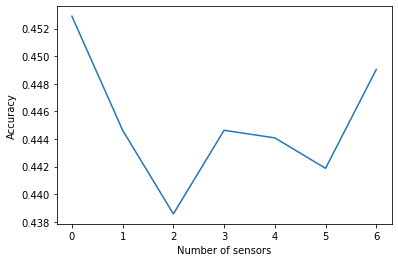

In [ ]:
poly_kernel = PolynomialKernel(d=2)

def polynomial_kernelize(X, d):
  def poly(x, d):
    return [e**d for e in x]
  return np.array([poly(x, d) for x in X])

def rbf_kernelize(X, sigma):
  def rbf(x, sigma):
    return [np.exp(-1/sigma * e**2) for e in x]

  return np.array([rbf(x, sigma) for x in X])

def xy_kernelize(X):
  def xy(x):
    return [a * b for a in x for b in x]
  return np.array([xy(x) for x in X])

X_train_np = X_train.to_numpy()
X_train_np_poly = np.hstack([polynomial_kernelize(X_train_np, deg) for deg in range(1, 20)] + [rbf_kernelize(X_train_np, 0.1)] + [xy_kernelize(X_train_np)])
#X_train_np_poly = polynomial_kernelize(X_train_np, 1)
X_test_np = X_test.to_numpy()
X_test_np_poly = np.hstack([polynomial_kernelize(X_test_np, deg) for deg in range(1, 20)] + [rbf_kernelize(X_test_np, 0.1)] + [xy_kernelize(X_test_np)])
#X_test_np_poly = polynomial_kernelize(X_test_np, 1)

accs = []
for i in range(100, 740, 100):
  
  sparse_model = SSPOC(n_sensors=i)
  sparse_model.fit(np.array(X_train_np_poly), np.array(y_train), quiet=True)
  #print(sparse_model.selected_sensors)
  acc = accuracy_score(np.array(y_test), sparse_model.predict(np.array(pd.DataFrame(X_test_np_poly).iloc[:,sparse_model.selected_sensors])))
  accs.append(acc)

plt.plot(accs)
plt.xlabel('Number of sensors')
plt.ylabel('Accuracy')
print(max(accs))

In [ ]:
rbf_kernelize(X_train_np, 3).shape

(5445, 37)

# Reconstruction for emojis

(19, 25600)
(16, 25600) (3, 25600)


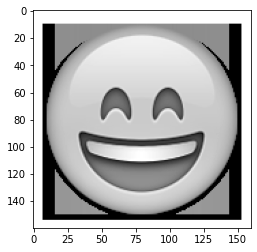

In [ ]:
lis = []
path = '/gdrive/MyDrive/me599/emoji-faces/'
for filename in os.listdir(path):
  
  image = cv2.imread(os.path.join(path,filename))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  arr = np.asarray(image).flatten()
  lis.append(arr)

imdata = np.array(lis)
print(imdata.shape)
np.random.shuffle(imdata)
train = imdata[:16,:]
test = imdata[16:,]
print(train.shape,test.shape) 
plt.imshow(imdata[0].reshape((160,160)), cmap='gray') 

In [ ]:
n_sensors = 10
model = SSPOR(n_sensors=n_sensors)
model.fit(train)

array([    0, 17662,  1604, 16717,  8753, 15769, 17212, 10292, 19461,
       19293], dtype=int32)

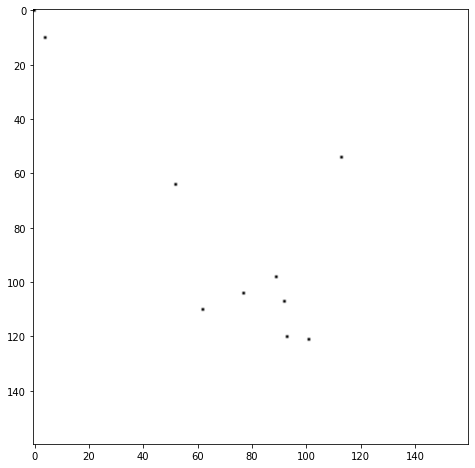

In [ ]:
ranked_sensors = model.get_selected_sensors()
ranked_sensors[:10]
#visualizing location of top n_sensors
img = np.zeros(25600)
img[ranked_sensors[:n_sensors]] = 16
plt.figure(figsize=(8,8))
plt.imshow(img.reshape((160,160)), cmap=plt.cm.binary)

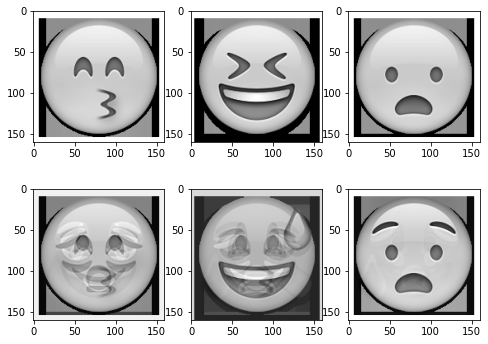

In [ ]:
test_s = test[:, ranked_sensors]

test_rc = model.predict(test_s)
fig,ax = plt.subplots(2,3, figsize=(8,6))
for i in range(len(test)):
  ax[0][i].imshow(test[i].reshape((160,160)), cmap='gray')
  ax[1][i].imshow(test_rc[i].reshape((160,160)), cmap='gray')

fig.show()  



In [ ]:
test_s.shape

In [ ]:
sensor_range = np.arange(2500,20000,100)
err = model.reconstruction_error(test,sensor_range=sensor_range)
plt.figure(figsize=(6,6))
plt.plot(sensor_range,err)
plt.title('Reconstruction error vs number of sensors')
plt.xlabel('Number of sensors')
plt.ylabel('Error')
plt.show()

# Cancer data classification

In [ ]:
cdata = pd.read_csv('/gdrive/MyDrive/me599/cancer-dataset/archive/data.csv')
cdata.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
cdata.columns

In [ ]:
y = cdata['diagnosis']
X = cdata.drop(['diagnosis', 'Unnamed: 32'], axis=1)

y_enc = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y_enc)

In [ ]:
X.info()

In [ ]:
X_train.shape, X_test.shape

In [ ]:
accs = []
number_basis = range(2, 30)
for b in number_basis:

  basis = ps.basis.SVD(n_basis_modes=b)
  model = SSPOC(basis=basis)
  model.fit(np.array(X_train),np.array(y_train),  quiet=True)
  sensors = model.get_selected_sensors()
  acc = accuracy_score(np.array(y_test), model.predict(np.array(X_test.iloc[:,sensors])))
  accs.append(acc)

accs_rp = []
for b in number_basis:
  basis = ps.basis.RandomProjection(n_basis_modes=b, eps=1)
  model = SSPOC(basis=basis)
  model.fit(np.array(X_train),np.array(y_train),  quiet=True)
  sensors = model.get_selected_sensors()
  acc = accuracy_score(np.array(y_test), model.predict(np.array(X_test.iloc[:,sensors])))
  accs_rp.append(acc)

In [ ]:
accs_rp

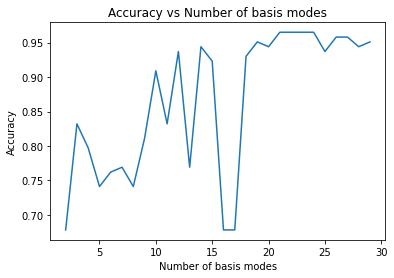

In [ ]:
plt.plot(number_basis,accs)
plt.title('Accuracy vs Number of basis modes')
plt.xlabel('Number of basis modes')
plt.ylabel('Accuracy')
plt.show()

#MNIST

In [ ]:
from keras.datasets import mnist
import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
x_train_flat = np.array([x.flatten() for x in x_train])
#x_test_flat = np.array([x.flatten() for x in x_test])

sparse_model = SSPOC(n_sensors = 650)
sparse_model.fit(x_train_flat, y_train, quiet=True)


SSPOC(basis=Identity(n_basis_modes=60000),
      classifier=LinearDiscriminantAnalysis(), n_sensors=650)

#Adding noise to test data

In [ ]:
from random import random
x_test_masked = np.zeros_like(x_test)
for i in range(len(x_test)):
  mask = np.ones_like(x_test[0])
  #masking some lower rows of the image
  stx1 = int(random() * 7 + 3)
  end1 = stx1 + int(random() * 20 + 7)
  stx2 = int(random() * 7 + 3)
  end2 = stx2 + int(random() * 20 + 7)
  mask[stx1:end1, stx2:end2, :] = 0
  x_test_masked[i] = np.multiply(x_test[i], mask)

x_test_flat = np.array([x.flatten() for x in x_test_masked])


8 30 10 19


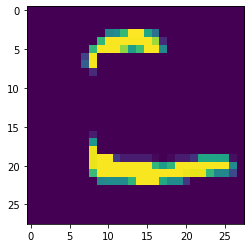

In [ ]:
print(stx1, end1, stx2, end2)
plt.imshow(x_test_masked[1].reshape(28,28))

#Evaluating on noisy data

In [ ]:
from keras import layers
num_classes = 10
input_shape = (28, 28,1)
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [ ]:
batch_size = 128
epochs = 10
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 33s 77ms/step - loss: 1.4209 - accuracy: 0.5471 - val_loss: 0.4634 - val_accuracy: 0.8715
Epoch 2/10
422/422 [==============================] - 39s 92ms/step - loss: 0.5179 - accuracy: 0.8395 - val_loss: 0.2897 - val_accuracy: 0.9195
Epoch 3/10
422/422 [==============================] - 41s 96ms/step - loss: 0.3833 - accuracy: 0.8835 - val_loss: 0.2122 - val_accuracy: 0.9430
Epoch 4/10
422/422 [==============================] - 33s 78ms/step - loss: 0.3108 - accuracy: 0.9057 - val_loss: 0.1687 - val_accuracy: 0.9563
Epoch 5/10
422/422 [==============================] - 32s 75ms/step - loss: 0.2632 - accuracy: 0.9212 - val_loss: 0.1437 - val_accuracy: 0.9635
Epoch 6/10
422/422 [==============================] - 31s 73ms/step - loss: 0.2348 - accuracy: 0.9287 - val_loss: 0.1271 - val_accuracy: 0.9688
Epoch 7/10
422/422 [==============================] - 31s 74ms/step - loss: 0.2168 - accuracy: 0.9354 - val_loss: 0.1172 - val_accuracy:

In [ ]:
#accuracy for sparse model is on masked data
sensors = sparse_model.get_selected_sensors()
print(accuracy_score(np.array(y_test), sparse_model.predict(np.array(x_test_flat[:,sensors]))))

score = model.evaluate(x_test_masked, y_test_cat)
print(score[1])

0.4532
313/313 [==============================] - 2s 7ms/step - loss: 3.0711 - accuracy: 0.3993
0.3993000090122223


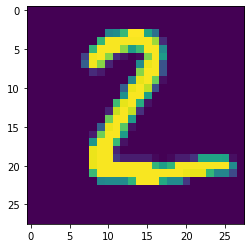

In [ ]:
plt.imshow(x_test[1].reshape(28,28))

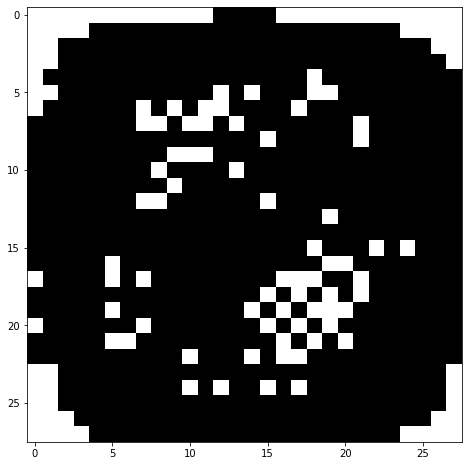

In [ ]:
ranked_sensors = sparse_model.get_selected_sensors()
ranked_sensors[:650]
#visualizing location of top n_sensors
img = np.zeros(28 * 28)
img[ranked_sensors[:650]] = 16
plt.figure(figsize=(8,8))
plt.imshow(img.reshape((28, 28)), cmap=plt.cm.binary)